In [1]:
# Isochronous and period-doubling diagrams for symplectic maps of the plane
# With JAX based indicators

# Ivan Morozov & Tim Zolkin & Sergey Kladov, 2025

In [2]:
# !pip install git+https://github.com/i-a-morozov/tohubohu.git@main

In [3]:
import numpy
import jax
import tohubohu

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import colormaps

# Set data type

jax.config.update("jax_enable_x64", True)

# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

# Mapping and symmetry lines

In [4]:
# Forward and inverse transformations

def quadratic_forward(x, w):
    q, p = x
    return jax.numpy.stack([p, -q + w*p + p**2])

def quadratic_inverse(x, w):
    q, p = x
    return jax.numpy.stack([-p + w*q + q**2, q])

# Symmetry lines

def quadratic_line_a(w, q):
    return q

def quadratic_line_b(w, q):
    return 0.5*(w*q + q**2)

# GALI

In [5]:
# Set indicator

gali = tohubohu.gali(2**12, quadratic_forward)

x = jax.numpy.array([0.0, 0.0])
w = jax.numpy.array(0.5)
v = jax.numpy.array([[1.0, 0.0], [0.0, 1.0]])

out = gali(x, v, w)

In [6]:
# Set grid

n = 1001

w = jax.numpy.linspace(-3.0, 2.0, n)
q = jax.numpy.linspace(-1.25, 1.75, n)
x = jax.numpy.stack(jax.numpy.meshgrid(w, q, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
x = jax.numpy.array_split(x, n)

In [7]:
# Set 'parametric' indicator

v = jax.numpy.array([[1.0, 0.0], [0.0, 1.0]])

def indicator(x, level=5.0E-16):
    w, q = x
    return jax.numpy.log10(level + gali(jax.numpy.stack([q, quadratic_line_b(w, q)]), v, w))

In [8]:
%%time

# Evaluate indicator
# Note, evaluation is splitted over 'batches'

xb, *xr = x
fj = jax.jit(jax.vmap(indicator))
out = [fj(xb)]

for xb in tqdm(xr):
    out.append(fj(xb))

out = jax.numpy.concatenate(out).reshape(n, n).block_until_ready()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.16it/s]


CPU times: user 1min 1s, sys: 174 ms, total: 1min 1s
Wall time: 1min


In [9]:
elbow = numpy.nan_to_num(out.flatten(), nan=100.0)
print(len(elbow))

elbow = elbow[elbow!= 100.0]
print(len(elbow))

1002001
309954


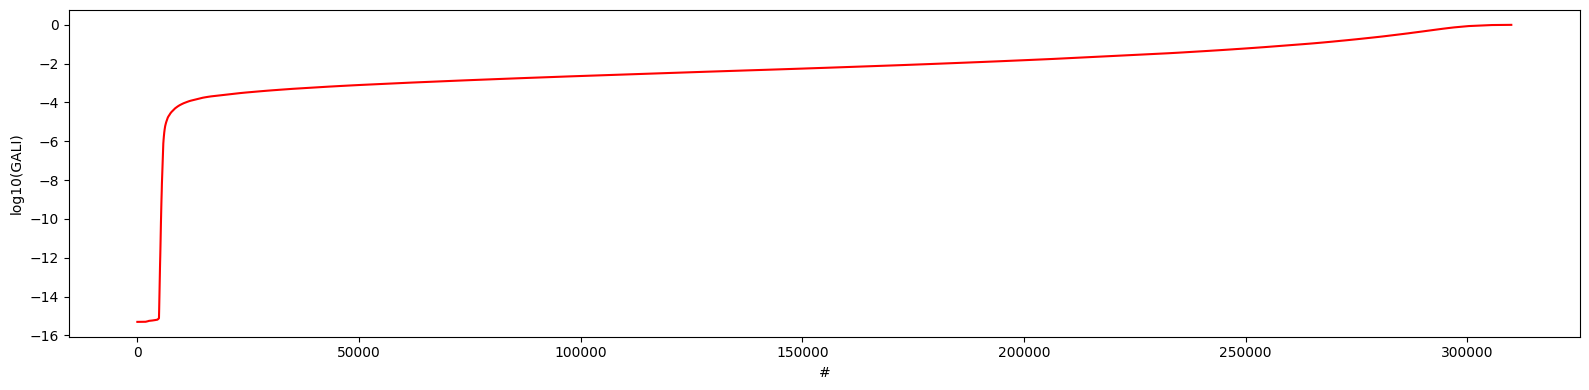

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(numpy.sort(elbow), color='red')
plt.xlabel('#')
plt.ylabel('log10(GALI)')
plt.tight_layout()
plt.show()

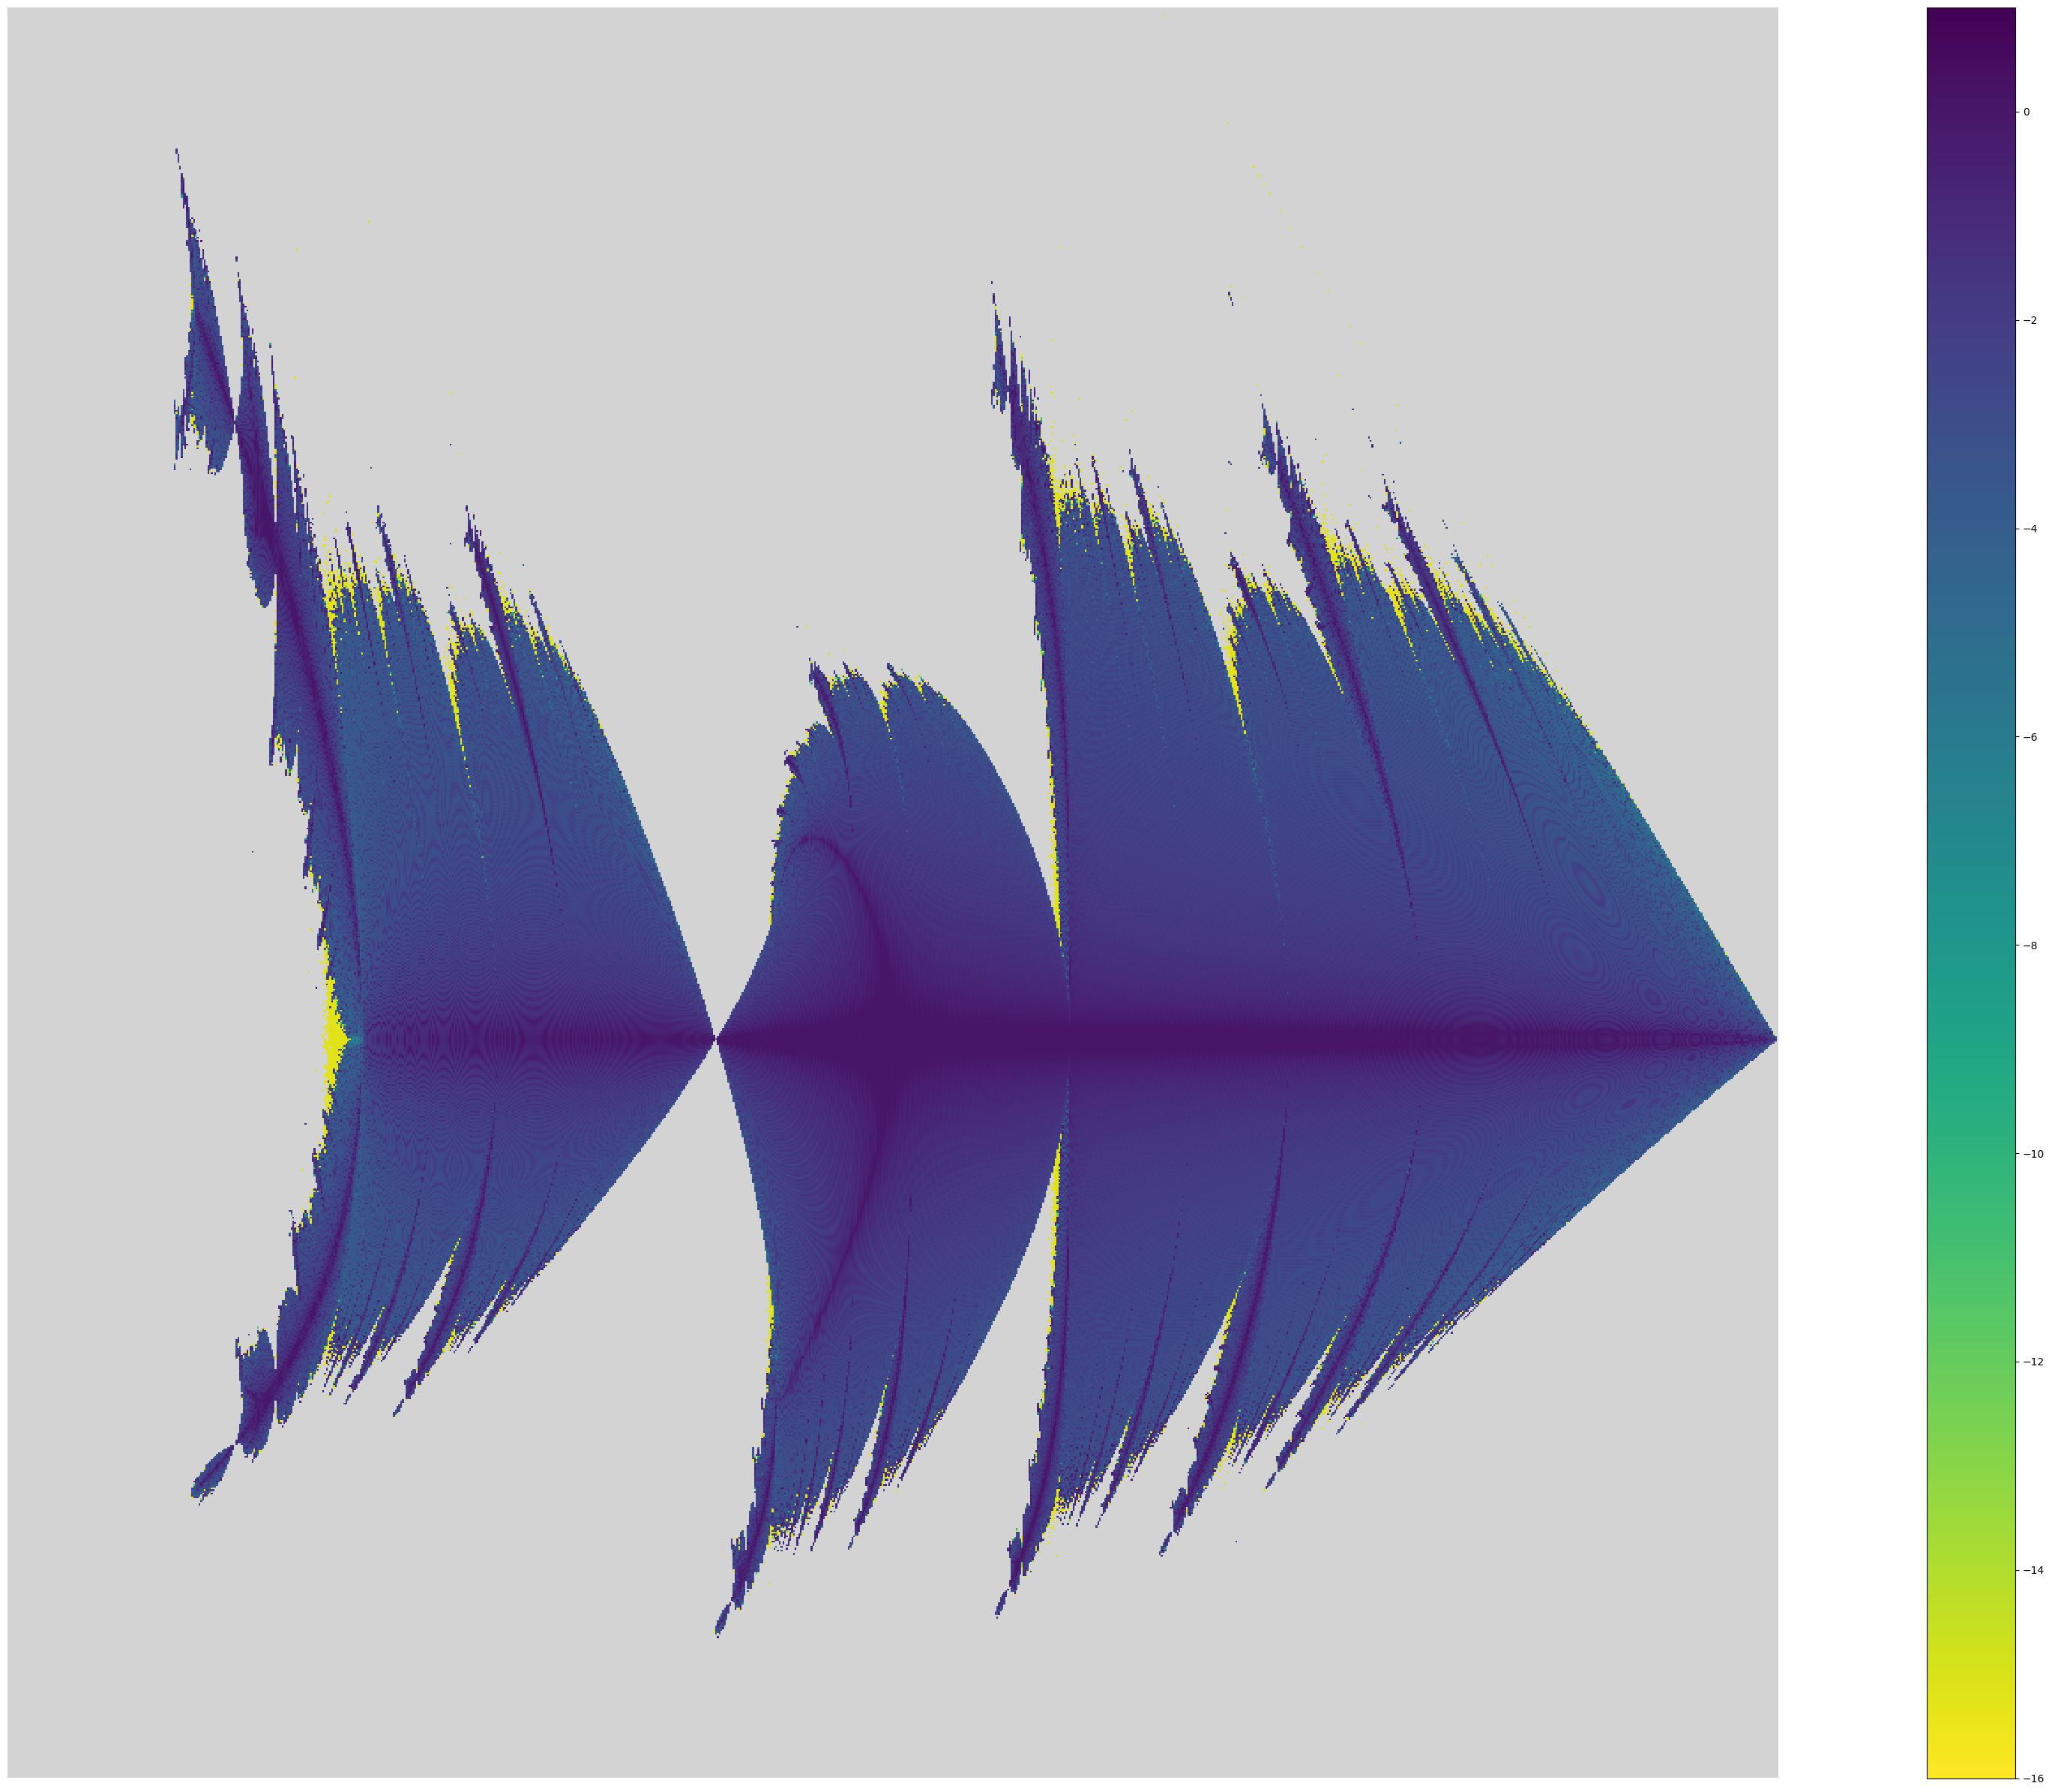

In [11]:
cmap = colormaps.get_cmap('viridis_r')
cmap.set_bad(color='lightgray')

plt.figure(figsize=(5*8, 3*8))
plt.imshow(out, aspect='equal', vmin=-16, vmax=1, origin='lower', cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()